In [1]:
#импорт библиотек
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os  

In [2]:
#variables
data='brl'

#импорт данных, сделать циклом
data = pd.read_csv(data+'/all_data.csv', sep=',')


In [3]:
#конвертация данных
data['Date'] = pd.to_datetime(data['Date'], dayfirst=False)


In [4]:
drop_data = data.copy()

In [5]:
#удаление пустых строчек
drop_data = drop_data.dropna(how='all')

In [6]:
#удаление пропусков спота из-за выходных и праздников
drop_data = drop_data.dropna(subset=['USDBRL Curncy'])


In [7]:
#добавление предыдущих форвард пойнтов в пустые места
drop_data['BCN1W BGN Curncy'] = drop_data['BCN1W BGN Curncy'].fillna(method='ffill')

In [8]:
#замена значений пропущенных значений признаков скользящим средним

window_size = 2  # Размер окна для вычисления скользящего среднего
for col in drop_data.select_dtypes(include=['int', 'float']):
    while drop_data[col].isnull().any(): 
        # Вычисляем скользящее среднее, игнорируя пропущенные значения
        drop_data[col] = drop_data[col].rolling(window=window_size, min_periods=1).mean()

In [9]:
#вычисление таргета

drop_data['target'] = (drop_data['USDBRL Curncy'].shift(1) - (drop_data['USDBRL Curncy'] + (drop_data['BCN1W BGN Curncy'] / 10000))) / drop_data['USDBRL Curncy'].shift(1)

#перенос последнего столбца на 4-тое место
new_columns = drop_data.columns[:-1].to_list()
new_columns.insert(1, 'target')
t_data_0 = drop_data[new_columns]
#удаление 'USDBRL Curncy' и 'BCN1W BGN Curncy' 
t_data = t_data_0.copy()
t_data.drop(['USDBRL Curncy', 'BCN1W BGN Curncy'], axis=1, inplace=True)
t_data.drop(0, axis=0, inplace=True)

In [10]:
#преобразование даты в секунды

# Преобразование datetime в секунды
t_data['Date'] = t_data['Date'].apply(lambda x: x.timestamp())

In [11]:
t_data=t_data.reset_index()

In [12]:
t_data=t_data.drop('index', axis=1)

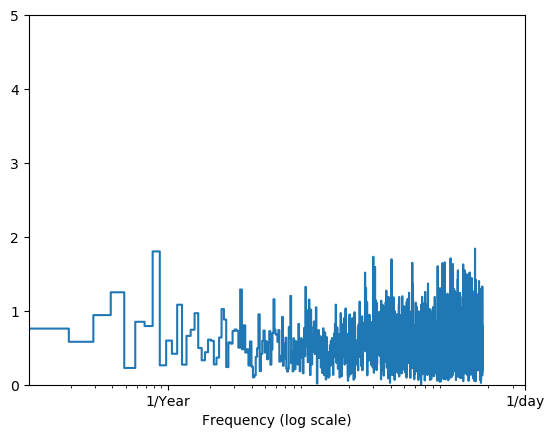

In [81]:
fft = tf.signal.rfft(t_data['target'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(t_data['target'])
hours_per_year = 365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 5)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


In [13]:
#разбиение данных
column_indices = {name: i for i, name in enumerate(t_data.columns)}

n = len(t_data)
train_df = t_data[0:int(n*0.7)]
val_df = t_data[int(n*0.7):int(n*0.9)]
test_df = t_data[int(n*0.9):]

num_features = t_data.shape[1]


In [14]:
#нормализация данных
#приведение таргета к диапазону от -5 до 5
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
train_df['target']=(train_df['target']-train_df['target'].min())*(10/(train_df['target'].max()-train_df['target'].min()))-5
val_df = (val_df - train_mean) / train_std
val_df['target']=(val_df['target']-val_df['target'].min())*(10/(val_df['target'].max()-val_df['target'].min()))-5
test_df = (test_df - train_mean) / train_std
test_df['target']=(test_df['target']-test_df['target'].min())*(10/(test_df['target'].max()-test_df['target'].min()))-5


In [83]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Date,2628.0,-5.191180e-16,1.00000,-1.722371,-0.871309,-0.002511,0.863103,1.737357
target,2628.0,1.513595e-02,0.76197,-5.000000,-0.362081,0.045672,0.426768,5.000000
EURUSD Curncy,2628.0,8.651966e-16,1.00000,-1.984432,-0.563645,0.165356,0.608537,2.249404
GBPUSD Curncy,2628.0,1.730393e-16,1.00000,-2.034321,-0.464497,-0.123947,0.213305,2.545909
USDJPY Curncy,2628.0,-8.003069e-16,1.00000,-1.703547,-0.785714,0.087021,0.835028,1.806416
USDMXN Curncy,2628.0,3.028188e-16,1.00000,-1.512895,-0.548850,-0.267523,0.316852,3.195968
USOSFR2 Curncy,2628.0,4.325983e-17,1.00000,-0.792728,-0.612208,-0.354942,0.004829,3.361957
USOSFR10 Curncy,2628.0,0.000000e+00,1.00000,-1.576388,-0.755223,-0.225176,0.659028,2.760112
CO1 Comdty,2628.0,1.514094e-16,1.00000,-2.034036,-0.974388,-0.050267,0.949234,2.310637
CU1 Comdty,2628.0,3.028188e-16,1.00000,-2.548768,-0.674748,0.056295,0.707288,2.058435


In [15]:
#создание класса окна
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [16]:
#сплит с учетом 
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [17]:
def plot(self, model=None, plot_col='target', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('days')

WindowGenerator.plot = plot

In [18]:
# создание tf.data.Dataset
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=20,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [20]:
#Одноступенчатые модели

In [84]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['target'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['target']

In [85]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (20, 1, 26)
Labels shape (batch, time, features): (20, 1, 1)


In [86]:
#базовый прогноз, озвращает текущую цену в качестве прогноза, прогнозируя «без изменений»
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


In [87]:
baseline = Baseline(label_index=column_indices['target'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


38/38 [==============================] - 0s 839us/step - loss: 2.7852 - mean_absolute_error: 1.2380


In [88]:
wide_window = WindowGenerator(
    input_width=50, label_width=50, shift=1,
    label_columns=['target'])

wide_window

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Label column name(s): ['target']

In [89]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (20, 50, 26)
Output shape: (20, 50, 1)


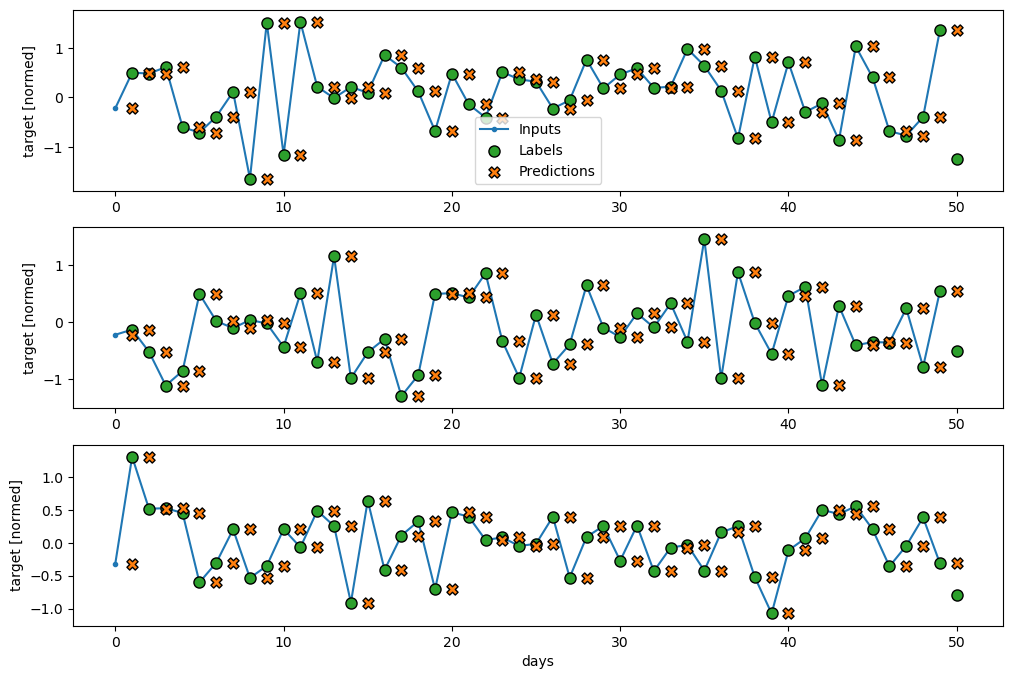

In [90]:
wide_window.plot(baseline)
#это просто метки, сдвинутые вправо на один день
    #Синяя линия Inputs показывает входную температуру на каждом временном шаге. Модель получает все функции, этот график показывает только температуру.
    #Зеленые точки Labels показывают целевое значение прогноза. Эти точки отображаются во время прогнозирования, а не во время ввода. Поэтому диапазон меток смещен на 1 шаг относительно входов.
    #Оранжевые кресты Predictions — это прогнозы модели для каждого выходного временного шага. Если бы модель предсказывала идеально, прогнозы попадали бы прямо в Labels .

In [91]:
# линейная модель
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])


In [92]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (20, 1, 26)
Output shape: (20, 1, 1)


In [104]:
MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=30):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [98]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


Epoch 1/300
132/132 [==============================] - 1s 2ms/step - loss: 0.5803 - mean_absolute_error: 0.5377 - val_loss: 1.6743 - val_mean_absolute_error: 1.0107
Epoch 2/300
132/132 [==============================] - 0s 2ms/step - loss: 0.5802 - mean_absolute_error: 0.5372 - val_loss: 1.7051 - val_mean_absolute_error: 1.0227
Epoch 3/300
132/132 [==============================] - 0s 1ms/step - loss: 0.5792 - mean_absolute_error: 0.5366 - val_loss: 1.7112 - val_mean_absolute_error: 1.0250
Epoch 4/300
132/132 [==============================] - 0s 1ms/step - loss: 0.5797 - mean_absolute_error: 0.5367 - val_loss: 1.6935 - val_mean_absolute_error: 1.0179
Epoch 5/300
132/132 [==============================] - 0s 1ms/step - loss: 0.5791 - mean_absolute_error: 0.5366 - val_loss: 1.7449 - val_mean_absolute_error: 1.0383
Epoch 6/300
132/132 [==============================] - 0s 2ms/step - loss: 0.5792 - mean_absolute_error: 0.5363 - val_loss: 1.7217 - val_mean_absolute_error: 1.0291
Epoch 7/30

In [99]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (20, 50, 26)
Output shape: (20, 50, 1)


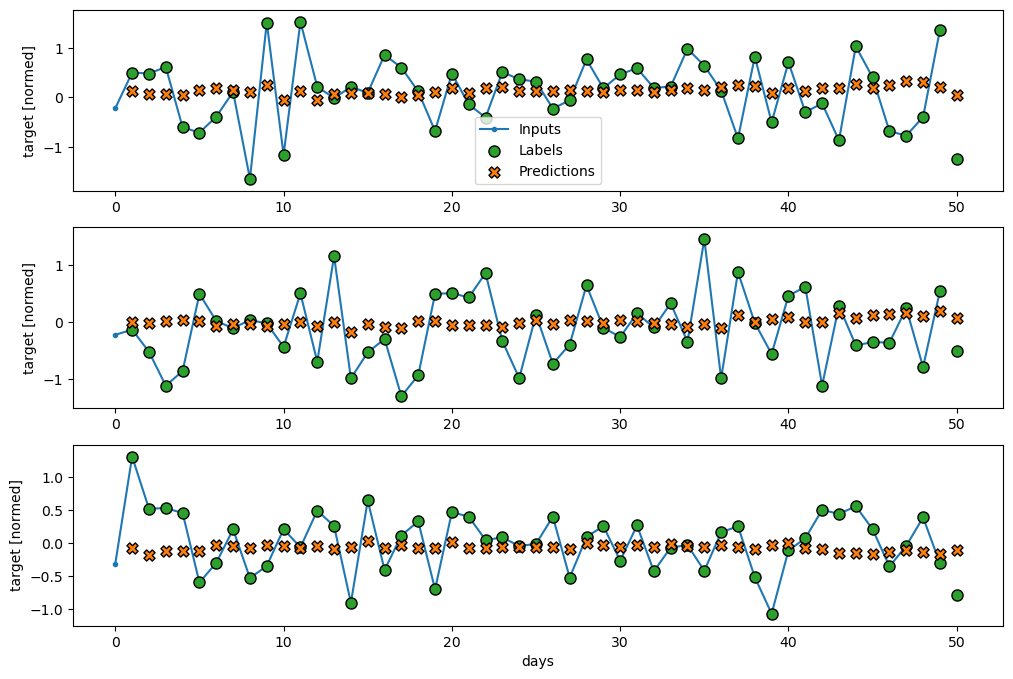

In [100]:
wide_window.plot(linear)


In [35]:
# плотный слой

In [123]:
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['target'])

conv_window


Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['target']

Text(0.5, 1.0, 'Given 3 days of inputs, predict 1 day into the future.')

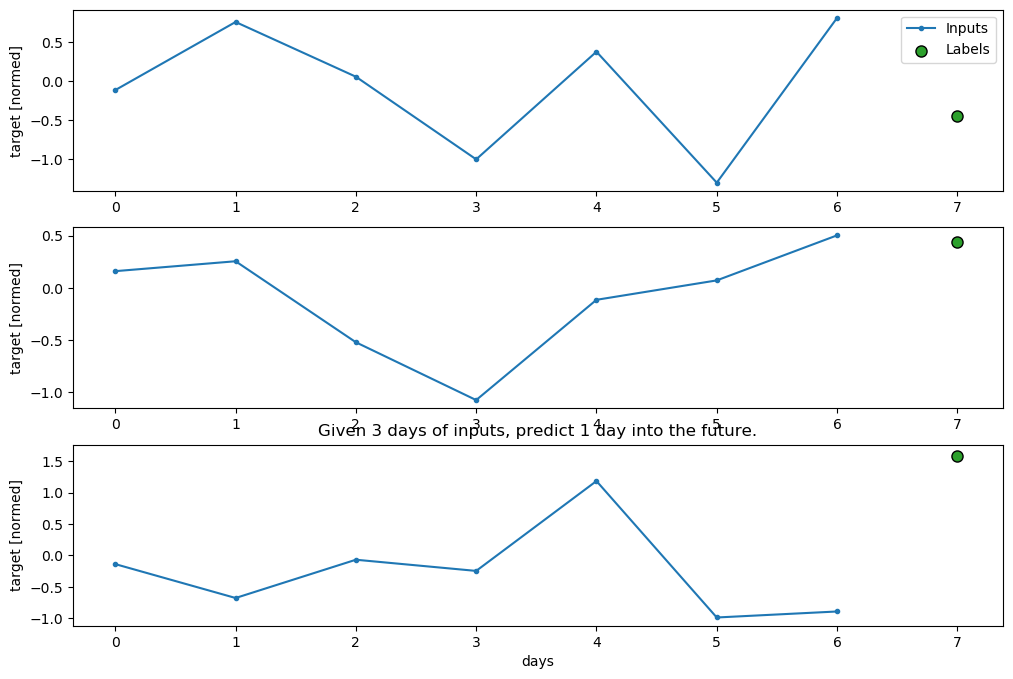

In [124]:
conv_window.plot()
plt.title("Given 3 days of inputs, predict 1 day into the future.")

In [125]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [126]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (20, 7, 26)
Output shape: (20, 1, 1)


In [127]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)


Epoch 1/30
132/132 [==============================] - 2s 3ms/step - loss: 0.6602 - mean_absolute_error: 0.5773 - val_loss: 1.5992 - val_mean_absolute_error: 0.9918
Epoch 2/30
132/132 [==============================] - 0s 2ms/step - loss: 0.6091 - mean_absolute_error: 0.5547 - val_loss: 1.8016 - val_mean_absolute_error: 1.0497
Epoch 3/30
132/132 [==============================] - 0s 2ms/step - loss: 0.5891 - mean_absolute_error: 0.5475 - val_loss: 1.6608 - val_mean_absolute_error: 0.9973
Epoch 4/30
132/132 [==============================] - 0s 2ms/step - loss: 0.5837 - mean_absolute_error: 0.5422 - val_loss: 1.8762 - val_mean_absolute_error: 1.0720
Epoch 5/30
132/132 [==============================] - 0s 2ms/step - loss: 0.5815 - mean_absolute_error: 0.5426 - val_loss: 2.1251 - val_mean_absolute_error: 1.1571
Epoch 6/30
132/132 [==============================] - 0s 2ms/step - loss: 0.5648 - mean_absolute_error: 0.5339 - val_loss: 2.5434 - val_mean_absolute_error: 1.2874
Epoch 7/30
132/1

In [128]:
from IPython.display import clear_output

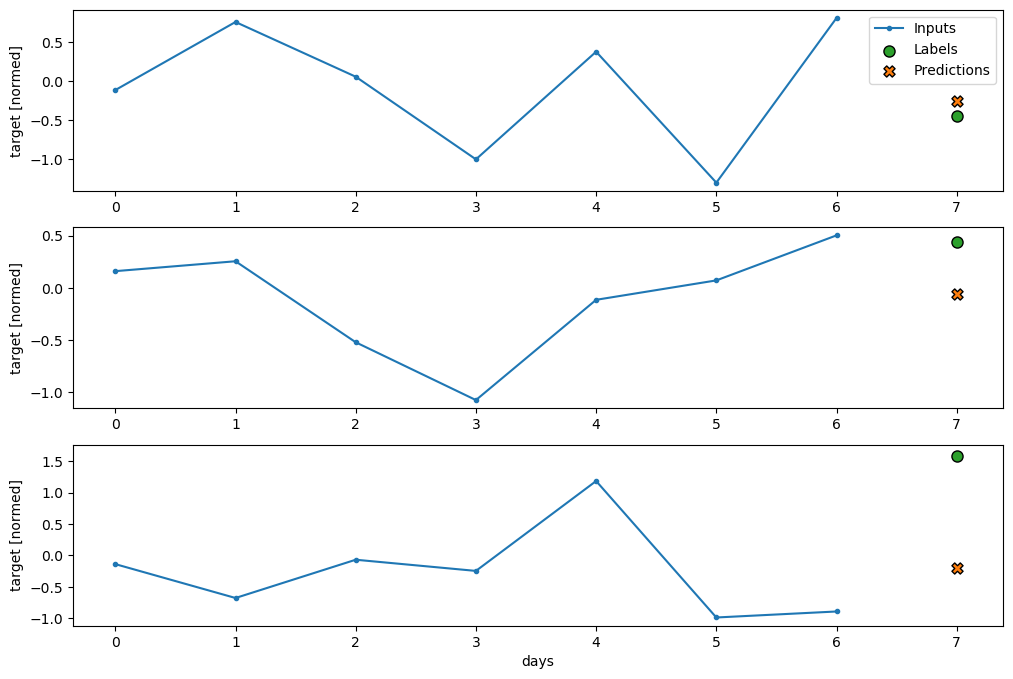

In [129]:
conv_window.plot(multi_step_dense)


In [151]:
#сверточная нейронная сеть
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=20,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [152]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (20, 7, 26)
Output shape: (20, 1, 1)


In [153]:
history = compile_and_fit(conv_model, conv_window)

#IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)


Epoch 1/30
132/132 [==============================] - 1s 2ms/step - loss: 0.6242 - mean_absolute_error: 0.5618 - val_loss: 1.5867 - val_mean_absolute_error: 0.9814
Epoch 2/30
132/132 [==============================] - 0s 2ms/step - loss: 0.6009 - mean_absolute_error: 0.5482 - val_loss: 1.7042 - val_mean_absolute_error: 1.0322
Epoch 3/30
132/132 [==============================] - 0s 1ms/step - loss: 0.5884 - mean_absolute_error: 0.5425 - val_loss: 1.6572 - val_mean_absolute_error: 1.0059
Epoch 4/30
132/132 [==============================] - 2s 13ms/step - loss: 0.5821 - mean_absolute_error: 0.5387 - val_loss: 1.4384 - val_mean_absolute_error: 0.9114
Epoch 5/30
132/132 [==============================] - 0s 1ms/step - loss: 0.5831 - mean_absolute_error: 0.5385 - val_loss: 1.7397 - val_mean_absolute_error: 1.0299
Epoch 6/30
132/132 [==============================] - 0s 1ms/step - loss: 0.5824 - mean_absolute_error: 0.5393 - val_loss: 1.8048 - val_mean_absolute_error: 1.0529
Epoch 7/30
132/

In [132]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (20, 50, 26)
Labels shape: (20, 50, 1)
Output shape: (20, 44, 1)


In [133]:
LABEL_WIDTH = 50
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['target'])

wide_conv_window

Total window size: 57
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56]
Label column name(s): ['target']

In [134]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (20, 56, 26)
Labels shape: (20, 50, 1)
Output shape: (20, 50, 1)


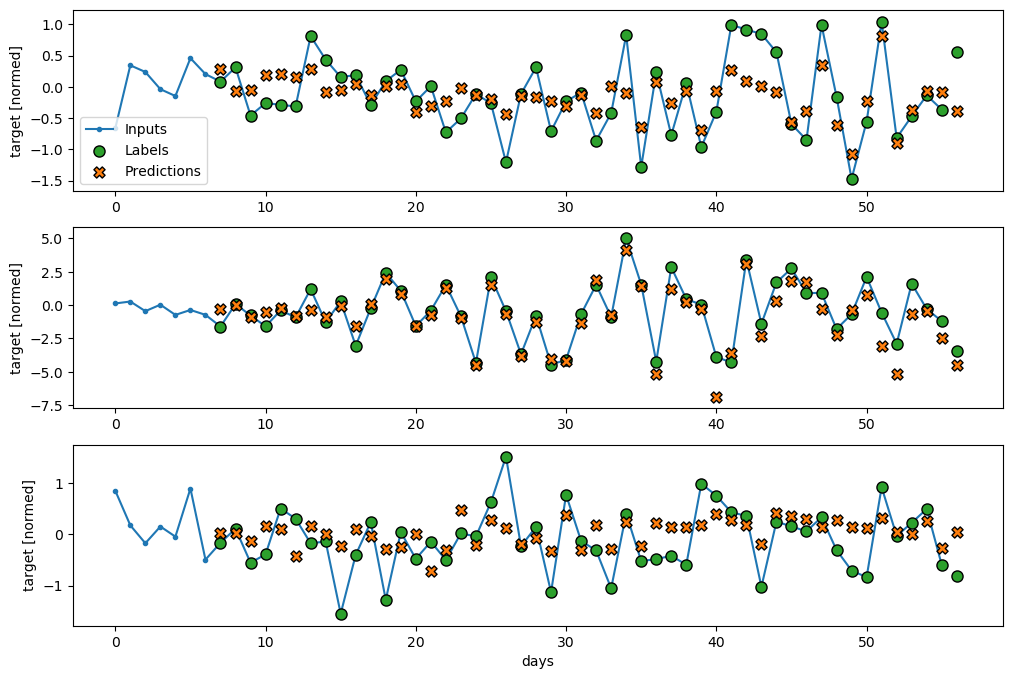

In [135]:
wide_conv_window.plot(conv_model)


In [145]:
#рекуррентная нейронная сеть lstm
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(20, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [146]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (20, 50, 26)
Output shape: (20, 50, 1)


In [147]:
history = compile_and_fit(lstm_model, wide_window)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


Epoch 1/30
129/129 [==============================] - 3s 12ms/step - loss: 0.5672 - mean_absolute_error: 0.5342 - val_loss: 1.6837 - val_mean_absolute_error: 1.0017
Epoch 2/30
129/129 [==============================] - 1s 10ms/step - loss: 0.5312 - mean_absolute_error: 0.5181 - val_loss: 1.9101 - val_mean_absolute_error: 1.0679
Epoch 3/30
129/129 [==============================] - 1s 10ms/step - loss: 0.5078 - mean_absolute_error: 0.5084 - val_loss: 1.8690 - val_mean_absolute_error: 1.0372
Epoch 4/30
129/129 [==============================] - 1s 10ms/step - loss: 0.4895 - mean_absolute_error: 0.5016 - val_loss: 1.8912 - val_mean_absolute_error: 1.0356
Epoch 5/30
129/129 [==============================] - 1s 11ms/step - loss: 0.4724 - mean_absolute_error: 0.4950 - val_loss: 1.9184 - val_mean_absolute_error: 1.0362
Epoch 6/30
129/129 [==============================] - 2s 12ms/step - loss: 0.4632 - mean_absolute_error: 0.4921 - val_loss: 1.9213 - val_mean_absolute_error: 1.0379
Epoch 7/30

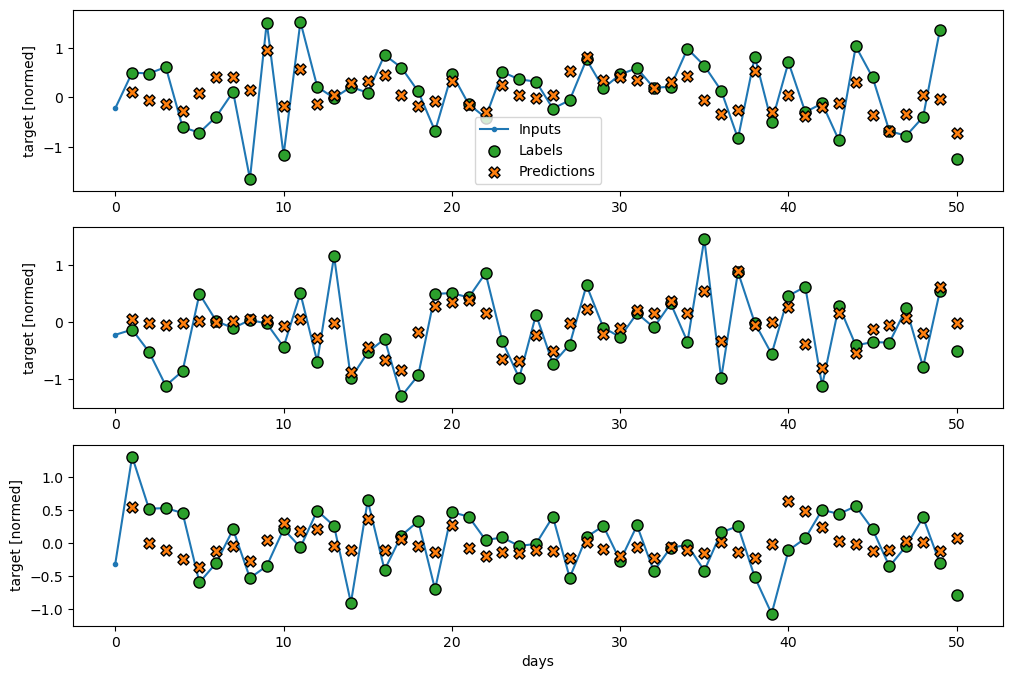

In [148]:
wide_window.plot(lstm_model)


In [149]:
#Performance

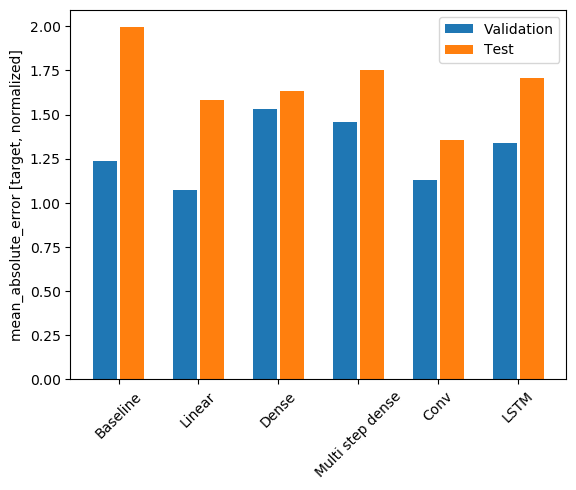

In [155]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [target, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [156]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 1.9934
Linear      : 1.5796
Dense       : 1.6357
Multi step dense: 1.7526
Conv        : 1.3547
LSTM        : 1.7076
